In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, box



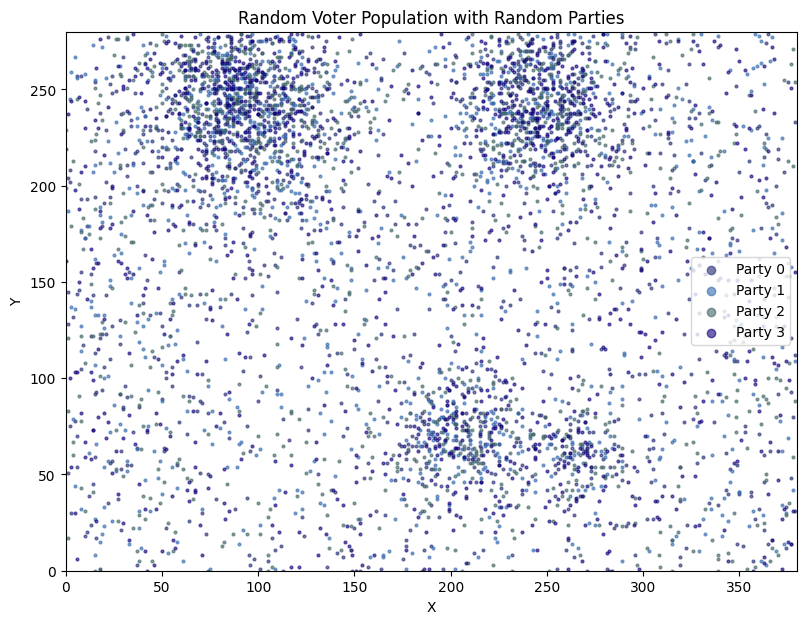

In [14]:
# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 5000

NUM_PARTIES = 4  # number of different parties/colors

# Random city parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# Base population density
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

# Generate random cities
for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

# ------------------------
# Sample voter coordinates
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign random parties/colors
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)  # random RGB colors

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,7))
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(voters[mask,0], voters[mask,1], 
                s=4, color=party_colors[i], label=f'Party {i}', alpha=0.6)

plt.title("Random Voter Population with Random Parties")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.show()


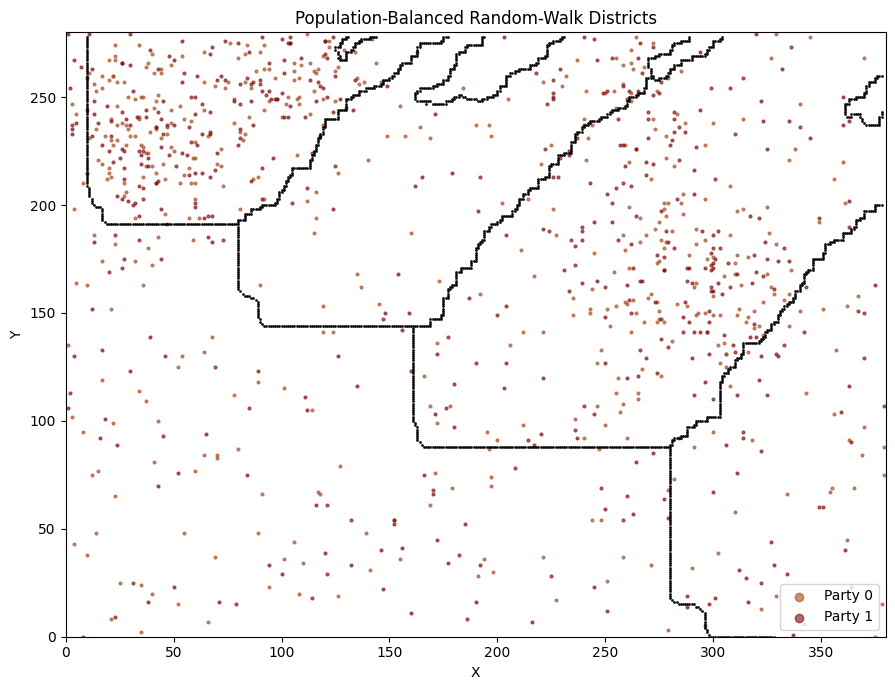

District 0: 84 voters
District 1: 71 voters
District 2: 1 voters
District 3: 0 voters
District 4: 2 voters
District 5: 317 voters
District 6: 340 voters
District 7: 1 voters


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 2
NUM_DISTRICTS = 8

# Random city parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# ------------------------
# Population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voter coordinates
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# Voters per cell
cell_population = np.zeros((HEIGHT, WIDTH), dtype=int)
for x, y in voters:
    cell_population[y, x] += 1

# ------------------------
# Assign random parties
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)

# ------------------------
# Balanced district growth
# ------------------------
district_map = -np.ones((HEIGHT, WIDTH), dtype=int)
district_population = np.zeros(NUM_DISTRICTS, dtype=int)

target_pop = NUM_VOTERS / NUM_DISTRICTS
tolerance = target_pop * 0.05  # 5% tolerance

# Pick random seed cells
seed_xs = np.random.randint(0, WIDTH, NUM_DISTRICTS)
seed_ys = np.random.randint(0, HEIGHT, NUM_DISTRICTS)

frontiers = [deque() for _ in range(NUM_DISTRICTS)]

for i in range(NUM_DISTRICTS):
    x, y = seed_xs[i], seed_ys[i]
    district_map[y, x] = i
    district_population[i] += cell_population[y, x]
    frontiers[i].append((x, y))

neighbors = [(1,0), (-1,0), (0,1), (0,-1)]

# Grow districts
active = True
while active:
    active = False

    for i in range(NUM_DISTRICTS):
        if district_population[i] >= target_pop + tolerance:
            continue
        if not frontiers[i]:
            continue

        active = True
        x, y = frontiers[i].popleft()
        np.random.shuffle(neighbors)

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
                if district_map[ny, nx] == -1:
                    district_map[ny, nx] = i
                    district_population[i] += cell_population[ny, nx]
                    frontiers[i].append((nx, ny))
                    break

# ------------------------
# Fill any unassigned cells
# ------------------------
unassigned = np.argwhere(district_map == -1)

for y, x in unassigned:
    neighbor_districts = []
    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy
        if 0 <= nx < WIDTH and 0 <= ny < HEIGHT:
            if district_map[ny, nx] != -1:
                neighbor_districts.append(district_map[ny, nx])

    if neighbor_districts:
        chosen = np.random.choice(neighbor_districts)
        district_map[y, x] = chosen
        district_population[chosen] += cell_population[y, x]

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10, 7))

# Plot voters
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(
        voters[mask, 0],
        voters[mask, 1],
        s=4,
        color=party_colors[i],
        label=f'Party {i}',
        alpha=0.6
    )

# Draw district boundaries
boundary_x = []
boundary_y = []

for y in range(HEIGHT - 1):
    for x in range(WIDTH - 1):
        d = district_map[y, x]
        if district_map[y+1, x] != d or district_map[y, x+1] != d:
            boundary_x.append(x)
            boundary_y.append(y)

plt.scatter(boundary_x, boundary_y, s=1, c='black', alpha=0.9)

plt.title("Population-Balanced Random-Walk Districts")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.tight_layout()
plt.show()

# ------------------------
# Print district populations
# ------------------------
for i, pop in enumerate(district_population):
    print(f"District {i}: {pop} voters")
